In [1]:
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers import Layer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.data_handling import load_dataset
from src.config import STRATEGY as strategy
from src.config import (BATCH_SIZE, IMAGE_SIZE, BATCH_SIZE, SIZE_RESIZE, AUTOTUNE, EPOCHS)

Number of replicas: 1


In [2]:
from src.utils import connect_to_tpu
a, st = connect_to_tpu()
st

Number of replicas: 1


## Load Data

In [3]:
MONET_FILENAMES = tf.io.gfile.glob("../images/artists/monet/monet_tfrec/*.tfrec")
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob("../images/random_images/photo_tfrec/*.tfrec")
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

monet_ds = load_dataset(MONET_FILENAMES, apply_jitter=True)
photo_ds = load_dataset(PHOTO_FILENAMES, apply_jitter=True)

photo_ds_test = load_dataset(PHOTO_FILENAMES, repeat=False, shuffle=False, batch_size=1)

Monet TFRecord Files: 5
Photo TFRecord Files: 20


2022-10-07 00:17:29.305169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-10-07 00:17:31.163602: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-10-07 00:17:31.747112: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


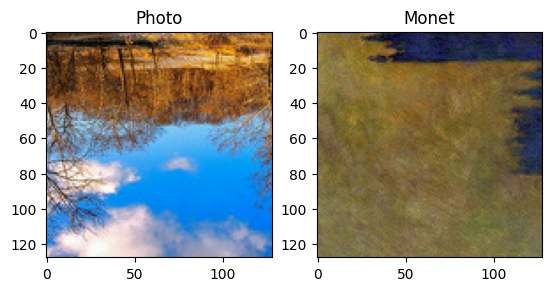

In [4]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [7]:
from src.models.cyclegan import CycleGan
from src.models.models import resnet, discriminator
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
N_MONET_SAMPLES = count_data_items(MONET_FILENAMES)
N_PHOTO_SAMPLES = count_data_items(PHOTO_FILENAMES)


with strategy.scope():
    monet_generator = resnet(height=None, width=None) # transforms photos to Monet-esque paintings
    photo_generator = resnet(height=None, width=None) # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator(height=None, width=None) # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator(height=None, width=None) # differentiates real photos and generated photos

with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

@tf.function
def linear_schedule_with_warmup(step):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """

    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.
    
    steps_per_epoch = int(max(N_MONET_SAMPLES, N_PHOTO_SAMPLES)//BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8
    
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

with strategy.scope():
    
    lr_monet_gen = lambda: linear_schedule_with_warmup(tf.cast(monet_generator_optimizer.iterations, tf.float32))
    lr_photo_gen = lambda: linear_schedule_with_warmup(tf.cast(photo_generator_optimizer.iterations, tf.float32))
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_monet_gen, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_photo_gen, beta_1=0.5)

    lr_monet_disc = lambda: linear_schedule_with_warmup(tf.cast(monet_discriminator_optimizer.iterations, tf.float32))
    lr_photo_disc = lambda: linear_schedule_with_warmup(tf.cast(photo_discriminator_optimizer.iterations, tf.float32))
    
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_monet_disc, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_photo_disc, beta_1=0.5)

with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    ) 

In [8]:
history = cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), 
                        epochs=EPOCHS,
                        steps_per_epoch=max(N_MONET_SAMPLES, N_PHOTO_SAMPLES)//BATCH_SIZE).history

Epoch 1/100
 10/439 [..............................] - ETA: 5:17:55 - monet_gen_loss: 8.3167 - photo_gen_loss: 8.4138 - monet_disc_loss: 0.6923 - photo_disc_loss: 0.6918

KeyboardInterrupt: 